<a href="https://colab.research.google.com/github/JankaUhrinova/Assessing-Unsupervised-Pretraining-for-improving-prediction-in-Digital-Pathology/blob/main/DCGAN_100K.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

For this evaluation, the code for DCGAN and the training process was based on the following tutorial: https://www.kaggle.com/code/tjac718/dcgan-on-mnist-dataset-using-pytorch

In [8]:
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import tensorflow as tf
import torch.nn.functional as F
import torchvision


In [9]:
torch.manual_seed(0)

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
transform=transforms.Compose([
    transforms.Resize([28,28]),
    transforms.ToTensor(),
    ])

In [13]:
dataset = torchvision.datasets.ImageFolder("/content/drive/MyDrive/bakalarka/NCT-CRC-HE-100K/NCT-CRC-HE-100K/", transform)

In [14]:
from torch.utils.data import random_split

In [15]:
random_train, others = random_split(dataset, [20000, 80000])

Visualization of the dataset

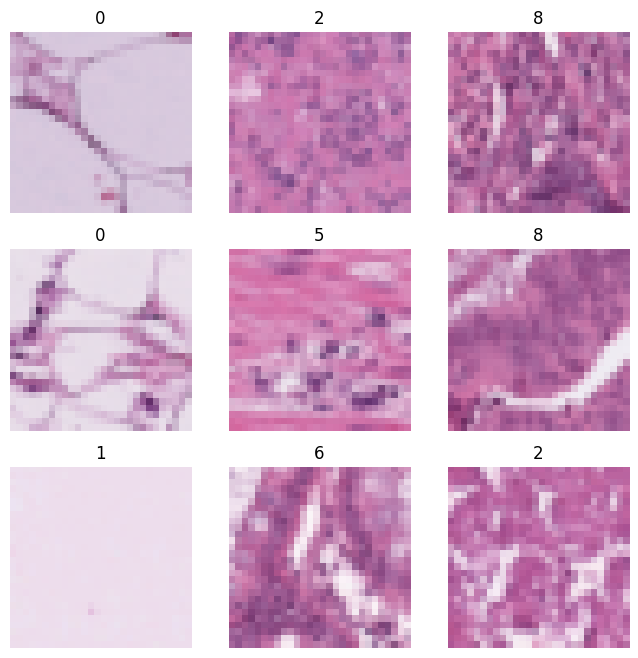

In [16]:
labels_map = {
    0: "0",
    1: "1",
    2: "2",
    3: "3",
    4: "4",
    5: "5",
    6: "6",
    7: "7",
    8: "8",
    9: "9",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(dataset), size=(1,)).item()
    img, label = dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.permute(1, 2, 0))
plt.show()

In [17]:
def random_noise_generator(batch_size, dim):
    return torch.rand(batch_size, dim)*2 - 1

In [32]:
training_dataloader = DataLoader(random_train, batch_size = 32)

In [40]:
class Discriminator(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv0 = nn.Conv2d(3, 32, kernel_size = 3, stride = 2, padding = 1)
        self.conv0_drop = nn.Dropout2d(0.25)
        self.conv1 = nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding = 1)
        self.conv1_drop = nn.Dropout2d(0.25)
        self.conv2 = nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1)
        self.conv2_drop = nn.Dropout2d(0.25)
        self.conv3 = nn.Conv2d(128, 256, kernel_size = 3, stride = 2, padding = 1)
        self.conv3_drop = nn.Dropout2d(0.25)
        self.fc = nn.Linear(12544, 1)
    
    def forward(self, x):
        x = x.view(-1, 3, 28, 28)
        x = F.leaky_relu(self.conv0(x), 0.2)
        x = self.conv0_drop(x)
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = self.conv1_drop(x)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = self.conv2_drop(x)
        x = F.leaky_relu(self.conv3(x), 0.2)
        x = self.conv3_drop(x)
        x = x.view(-1, self.num_flat_features(x))
        x = self.fc(x)
        
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        
        return num_features

In [41]:
class Generator(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(100, 256*7*7)
        self.trans_conv1 = nn.ConvTranspose2d(256, 128, kernel_size = 3, stride = 2, padding = 1, output_padding = 1)
        self.trans_conv2 = nn.ConvTranspose2d(128, 64, kernel_size = 3, stride = 1, padding = 1)
        self.trans_conv3 = nn.ConvTranspose2d(64, 32, kernel_size = 3, stride = 1, padding = 1)
        self.trans_conv4 = nn.ConvTranspose2d(32, 3, kernel_size = 3, stride = 2, padding = 1, output_padding = 1)
    
    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, 256, 7, 7)
        x = F.relu(self.trans_conv1(x))
        x = F.relu(self.trans_conv2(x))
        x = F.relu(self.trans_conv3(x))
        x = self.trans_conv4(x)
        x = torch.tanh(x)
        
        return x 

In [42]:
discriminator = Discriminator()
generator = Generator()

#Sanity check of the model instances
print(discriminator)
print(generator)

#Passing to the GPU
discriminator = discriminator.to(device)
generator = generator.to(device)

discriminator = discriminator.float()
generator = generator.float()

Discriminator(
  (conv0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv0_drop): Dropout2d(p=0.25, inplace=False)
  (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_drop): Dropout2d(p=0.25, inplace=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_drop): Dropout2d(p=0.25, inplace=False)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3_drop): Dropout2d(p=0.25, inplace=False)
  (fc): Linear(in_features=12544, out_features=1, bias=True)
)
Generator(
  (fc): Linear(in_features=100, out_features=12544, bias=True)
  (trans_conv1): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (trans_conv2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (trans_conv3): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (trans_conv4): ConvTranspose2d(32, 3, 

In [43]:
Loss = nn.BCEWithLogitsLoss()
def discriminator_real_loss(real_out):
    real_label = torch.ones(real_out.size()[0], 1).to(device)
    real_loss = Loss(real_out.squeeze(), real_label.squeeze())
    return real_loss

def discriminator_fake_loss(fake_out):
    fake_label = torch.zeros(fake_out.size()[0], 1).to(device)
    fake_loss = Loss(fake_out.squeeze(), fake_label.squeeze())
    return fake_loss

def discriminator_loss(real_out, fake_out):
    real_loss = discriminator_real_loss(real_out)
    fake_loss = discriminator_fake_loss(fake_out)
    total_loss = (real_loss + fake_loss)
    return total_loss

def generator_loss(gen_disc_out):
    label = torch.ones(gen_disc_out.size()[0], 1).to(device)
    gen_loss = Loss(gen_disc_out.squeeze(), label.squeeze())
    return gen_loss

In [47]:
disc_opt = optim.Adam(D.parameters(), lr = 0.0002, betas = (0.5, 0.999))
gen_opt = optim.Adam(generator.parameters(), lr = 0.0002, betas = (0.5, 0.999))

In [52]:
def train(D, G, disc_opt, gen_opt, train_dl, batch_size = 32, epochs = 10, gen_input_size = 100):
    
    disc_losses = []
    gen_losses = []
    
    #Having a fixed sample to monitor the progress of the generator
    sample_size = 4
    samples = random_noise_generator(sample_size, gen_input_size)
    samples = samples.to(device)
    
    #Going into training mode
    D.train()
    generator.train()
    
    for epoch in range(epochs + 1):
        
        disc_loss_total = 0
        gen_loss_total = 0
        gen_out = 0
        i = 0

        for train in train_dl:
            #Discriminator training
            disc_opt.zero_grad()
            if i%100 == 0:
              print(i)
            i += 1
            train_x = train[0]*2 - 1          
            train_x = train_x.to(device)  
            real_out = D(train_x.float())    
            disc_gen_in = random_noise_generator(batch_size, gen_input_size)
            disc_gen_in = disc_gen_in.to(device)
            
            disc_gen_out = G(disc_gen_in.float()).detach() 
            fake_out = D(disc_gen_out.float())
            disc_loss = discriminator_loss(real_out, fake_out)  
            disc_loss_total += disc_loss
            disc_loss.backward()
            disc_opt.step()  
        
            #Generator training
            gen_opt.zero_grad()
            gen_out = G(disc_gen_in.float())   
            gen_disc_out = D(gen_out.float())      
            
            gen_loss = generator_loss(gen_disc_out)  #Generator loss calculation
            gen_loss_total += gen_loss
            gen_loss.backward()
            gen_opt.step()
        
        disc_losses.append(disc_loss_total)
        gen_losses.append(gen_loss_total)
        
        #Plotting samples every 2 epochs
        if epoch%2 == 0:
            generator.eval()                    
            generated = G(samples.float())
            generator.train()          
            
            fig, axes = plt.subplots(figsize=(7,7), nrows=1, ncols=4, sharey=True, sharex=True)
            for ax, img in zip(axes.flatten(), generated):
               img = (img+1)/2
               img = img.cpu().detach()
               ax.xaxis.set_visible(False)
               ax.yaxis.set_visible(False)
               im = ax.imshow(img.permute(1, 2, 0))
        
        
        #Printing losses every epoch
        print("Epoch ", epoch, ": Discriminator Loss = ", disc_loss_total/len(train_dl), ", Generator Loss = ", gen_loss_total/len(train_dl))    
    
    return disc_losses, gen_losses

0
100
200
300
400
500
600
Epoch  0 : Discriminator Loss =  tensor(1.3295, device='cuda:0', grad_fn=<DivBackward0>) , Generator Loss =  tensor(0.8134, device='cuda:0', grad_fn=<DivBackward0>)
0
100
200
300
400
500
600
Epoch  1 : Discriminator Loss =  tensor(1.3395, device='cuda:0', grad_fn=<DivBackward0>) , Generator Loss =  tensor(0.7793, device='cuda:0', grad_fn=<DivBackward0>)
0
100
200
300
400
500
600
Epoch  2 : Discriminator Loss =  tensor(1.3469, device='cuda:0', grad_fn=<DivBackward0>) , Generator Loss =  tensor(0.7741, device='cuda:0', grad_fn=<DivBackward0>)
0
100
200
300
400
500
600
Epoch  3 : Discriminator Loss =  tensor(1.3484, device='cuda:0', grad_fn=<DivBackward0>) , Generator Loss =  tensor(0.7662, device='cuda:0', grad_fn=<DivBackward0>)
0
100
200
300
400
500
600
Epoch  4 : Discriminator Loss =  tensor(1.3482, device='cuda:0', grad_fn=<DivBackward0>) , Generator Loss =  tensor(0.7728, device='cuda:0', grad_fn=<DivBackward0>)
0
100
200
300
400
500
600
Epoch  5 : Discrimi

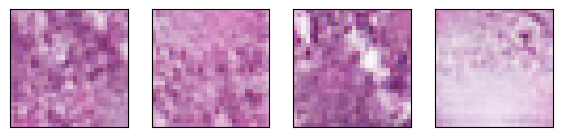

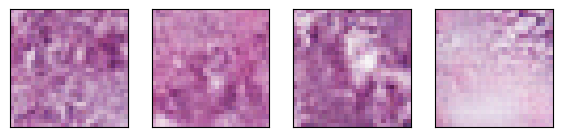

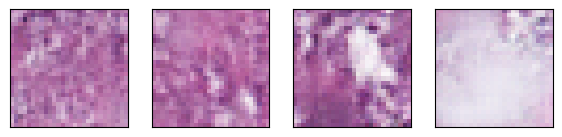

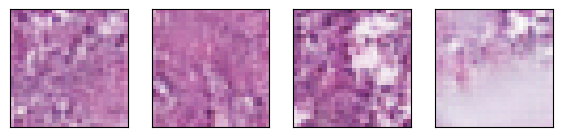

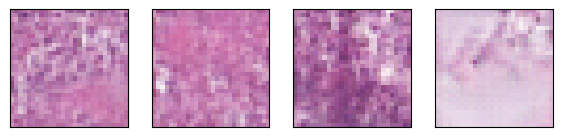

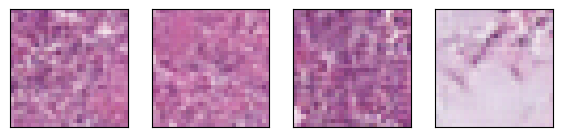

In [53]:
disc_losses, gen_losses = train(D, G, disc_opt, gen_opt, training_dataloader, 32)